<a href="https://colab.research.google.com/github/JuanDaGue/Seminario/blob/main/1_Ensayos_pyemcee_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emcee
!pip install corner

     |████████████████████████████████| 45 kB 1.7 MB/s 


In [ ]:
import numpy as np
import matplotlib.pylab as plt
from numpy import math
from scipy.optimize import curve_fit
import seaborn as sns
from scipy import stats
from scipy.stats import *
import pandas as pd
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import arviz as az
import emcee
import seaborn as sns
import corner
import pymc3 as pm

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving figure1_plotdata.csv to figure1_plotdata.csv


# Implementación del modelo a los datos de .....

Los datos optenidos de https://loco.lab.asu.edu/edges/edges-data-release/, los cuales contienen la siguiente información **Frequency [MHz], Weight, a: Tsky [K], b: Tres1 [K], c: Tres2 [K], d: Tmodel [K], e: T21 [K]**

Donde la frecuencia y el peso son nuestros y a,b,c,d,e son nuestros parametros 

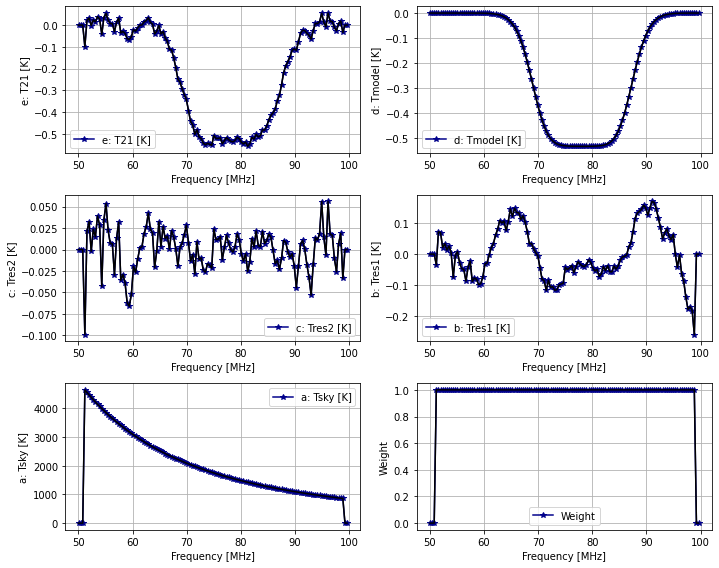

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(10, 8))
for i, ax in enumerate(axes.flat, start=0):
    ax.plot(Dat[:,0],Dat[:,6-i],color='darkblue',marker='*',label=Names[6-i])
    ax.plot(Dat[:,0],Dat[:,6-i],color='k')
    ax.set_xlabel(Names[0] )
    ax.set_ylabel(Names[6-i] )
    ax.grid()
    ax.legend()
fig.tight_layout()

plt.show()

## Modelo

Los datos para nuestro modelo son frecuenciua vs temperatura sky.
 El modelo consiste en obtener $T_{sky}$ como la suma de $T_F$ (-.--------)y $T_{21}$ (Temperatura relacionada a la trancicion de 21 cm) $T_{sky}=T_F(\nu)+T_{21}(\nu)$
 
$T_F( \nu)$ esta modelada por la siguiente ecuación 

$$T_F(\nu)=a_o\left(\frac{\nu}{\nu_c}\right)^{-2.5}+a_1\left(\frac{\nu}{\nu_c}\right)^{-2.5}\log\left(\frac{\nu}{\nu_c}\right)+a_2\left(\frac{\nu}{\nu_c}\right)^{-2.5}\left[\log\left(\frac{\nu}{\nu_c}\right)\right]^2+a_3\left(\frac{\nu}{\nu_c}\right)^{-4.5}+a_4\left(\frac{\nu}{\nu_c}\right)^{-2.0}+$$

donde $T_F ( ν )$ es la temperatura de brillo de la emisión de primer plano, $ν$ es lafrecuencia, $ν_c$ es la frecuencia central de la banda observada y los coeficientes $a_n$ se ajustan a los datos. La función anterior es una aproximación lineal, centrada en $ν_c$ ,
$T_{21}$ tiene la siguiente expresón 
$$T_{21}=-A\left[\frac{1-e^{\tau e^B}}{1-e^{-\tau}}\right]$$

Donde 
$$B=\frac{4(v-\nu_o)^2}{w^2}\log\left(-{1\over \tau }\log\left({{1+e^{-\tau}}\over 2}\right)\right)$$


In [ ]:
Dat=np.loadtxt('figure1_plotdata.csv',delimiter=',',skiprows=1)
Names=np.array(['Frequency [MHz]', 'Weight', 'a: Tsky [K]', 'b: Tres1 [K]', 'c: Tres2 [K]','d: Tmodel [K]', 'e: T21 [K]'
])

In [ ]:
# los datos de estas constantes estan el kelvin, al igual que los datos tomados de EDGES
Bow= 1570, 700,-1100,750,-175,0.530,78.3,20.75,8.0,0.05             # intersección con el eje y
Col=['b','r','darkorange','darkmagenta','gold','g','khaki','r','indigo','teal']
Cons=np.array([Bow,Pyemcee,Pyemcee2,Intento,Natu_result,Natu])
Cons_names=np.array(['Bow','Pyemcee','Pyemcee2','Natu_result','Intento','Natu'])

In [ ]:
x,y=Dat[:,0][Dat[:,2]>0],Dat[:,2][Dat[:,2]>0] # Variables
# Datos cortados
x_C,y_C=Dat[:,0][Dat[:,0]>60.0] ,Dat[:,2][Dat[:,0]>60.0] # Variables
x_C,y_C=x_C[x_C<94.0],y_C[x_C<94.0]

In [ ]:
"""
Funciones de la temperatura 
Sky
"""
##################################0-
def T_f(v,a0,a1,a2,a3,a4):
  vc=np.median(v) #Frecuancia central
  vc=78.0 # frecuancia central (EDGES) 
  return a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2
def T_21(v,A,v0,w,tau):
  B=((4*(v-v0)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
  return-A*(1-(np.e**(-tau*(np.e)**(B))))/(1-(np.e**(-tau)))

def T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau):
  T21= T_21(v,A,v0,w,tau)
  Tf= T_f(v,a0,a1,a2,a3,a4)
  return T21+Tf

def T_sky_s(v,a0,a1,a2,a3,a4,A,v0,w,tau,sigma):
  T21= T_21(v,A,v0,w,tau)
  Tf= T_f(v,a0,a1,a2,a3,a4)
  return T21+Tf

## Función de Discrepancia



Después de tener en muestreo de las función posterior, obtenidas con $\textit{pyemcee}$ y de verificar que los datos ajustan la señal de Tsky, se prueba si el los datos sinteticos obtenidos mediante el modelo, discrepan de los datos observados.

En la siguiente función se usa el criterio de $\text{F. Tuky}$ para comparar los datos que obtuvimos de nuestro muestreo con los observados y hacer una gráfico de ellos y arrojar el valor del parámetro de discrepancia $p$


In [ ]:
def disc_sgg_s(ii,samples,x,y,Dsin,Dobs):
  #arreglos vacios para guardad los valores de la discrepancia simulada y observada 
  discs=[] 
  disco=[]

  rej=0 ## Tasa de rechazo
  #samples=rr_s[ii,:,:]#parametros
  #yexp=(samples[i,0]*x+samples[i,3])**2+samples[i,1]**2
  #yexp=np.sqrt(yexp)
  #samples[:,0]
  n_100=len(samples)//10 # Candtidad de elementos a selecionar del nwalkers
  for i in range(n_100):
    # yexp es una arreglo que contiene  
    #yexp=T_sky(x,samples[i,0],samples[i,1],samples[i,2],samples[i,3],samples[i,4],samples[i,5],samples[i,6],samples[i,7],samples[i,8] )
    yexp=(T_sky_s(x,*samples[i]))
    modpar=samples[np.random.randint(len(samples))] # Elige un conjunto de parametos de forma aleatoria de la muestra
    # Con los parametros del modelo, generamos datos sintéticos
    ymod=T_sky_s(x,*modpar) # Tsky modelo
    #ymod=np.sqrt(ymod)
    ysim=np.random.normal(ymod,abs(np.mean(samples[:,9]))) #Generando datos sinteticos
    if np.any(yexp<0)|np.any(ysim<0):
        rej+=1 # this checks if a negative ysim is generated
    else:        
        discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()] # se guardan los valores de la discrepacia simulada (Freeman-Tukey)
        disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()] # Se guadan los valores de la discrepacia observada (Freeman-Tukey)
  print("Rejection rate =",100*rej//n_100,"%") #fraccion de veces que un número negativo fue generado
  if 100*rej//n_100 < 100:
      discs=np.array(discs)
      disco=np.array(disco)
      Dsin[ii]=discs
      Dobs[ii]=disco
      # make the discrepancy plot
      ax.scatter(disco,discs,color='darkblue',alpha=0.4,label=str(ii)+", Bayesian p-value:"+str(np.round((disco<discs).sum()*1./len(disco),2)))
      dmax=np.max(np.hstack((disco,discs)))
      dmin=np.min(np.hstack((disco,discs)))
      ppp=np.linspace(0,dmax+10,2)
      ax.plot(ppp,ppp,c='r')
      ax.set_xlim(dmin,dmax)
      ax.set_ylim(dmin,dmax)
      # the Bayesian "p-value" is the fraction of discrepancy realizations 
      # when the observed discrepancy is lower than the simulated discrepancy
      # ideally this "p-value" should not be close to 0 or 1
      print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

In [ ]:
names=np.array(['a0','a1','a2','a3','a4','A','v0','w','tau'])
ds=pd.read_csv('figure1_plotdata.csv',sep=',')
ds.head()
ds2=ds[ds.iloc[:,2]>1.0] 

#Pyemcee discrepancia ok

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, tau, w, v0, A, a4, a3, a2, a1, a0]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 1539 seconds.


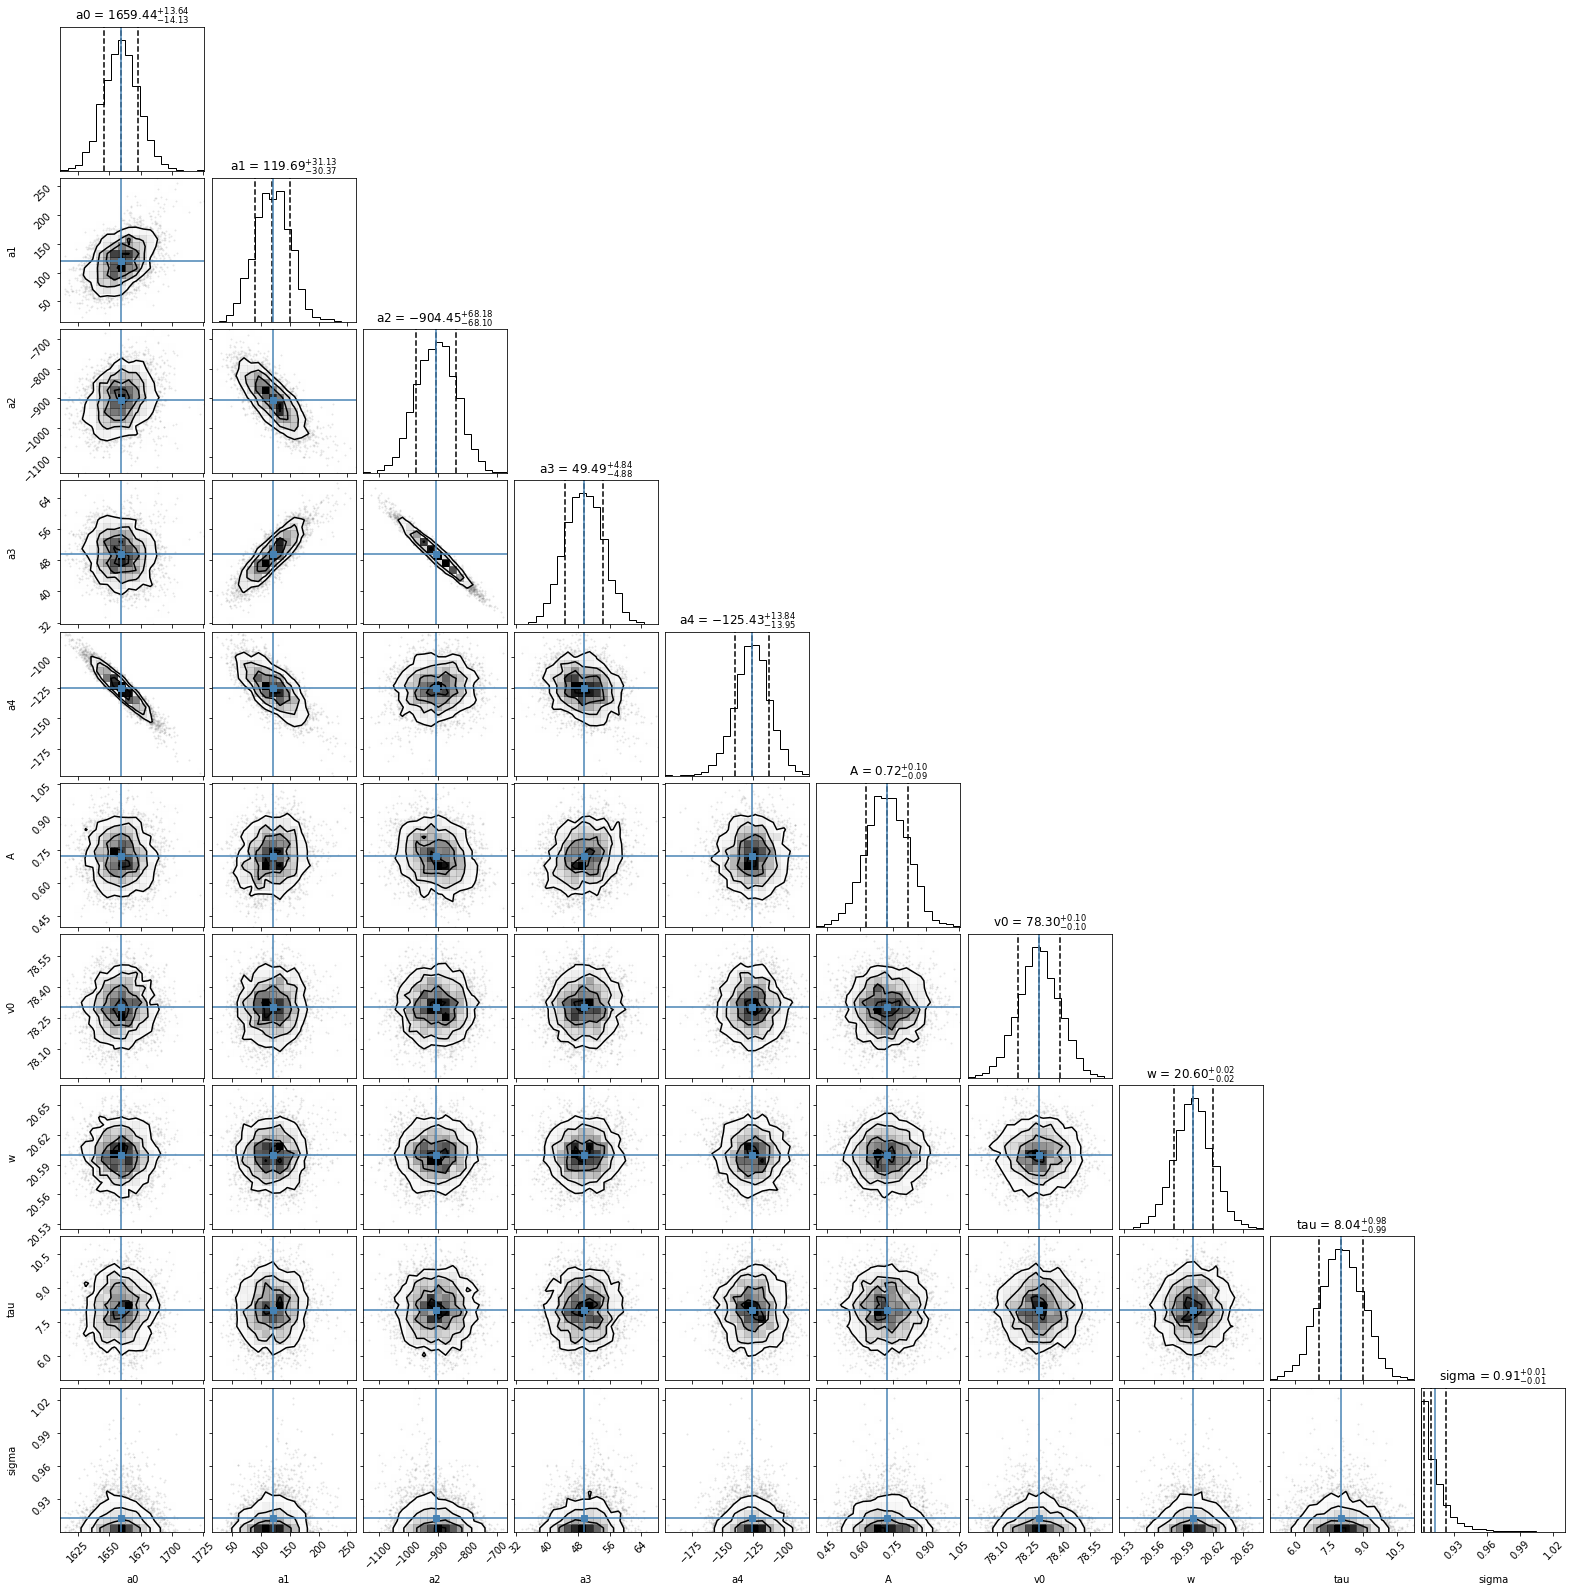

In [ ]:
d1=x # Valores de frecuencia [Mhz]
d2=y # Valores de la temperatura [Mk]
N=2000
cc_g31=np.zeros((len(Cons),len(Cons[0])))  # Este arreglo vacio, va a contener los valores principales de los parametros
rr_g31=np.zeros((len(Cons),2*N,len(Cons[0]))) #Este arreglo vacio va a contener los n walkers  de los parametros
#v=d1.freq-d1.freq.mean()/d1.freq.std()
v=d1#.freq
vc=78.0
Nlen=1
for i in range(Nlen):
  a_0,a_1,a_2,a_3,a_4,A_,v_0,w_,tau_,sigma_=Cons[i]
  with pm.Model() as pred_model:
        vc=78.01
        a0=pm.Normal('a0',mu=1590,sd=20)
        a1=pm.Normal('a1',mu=660,sd=80)
        a2=pm.Normal('a2',mu=-1100,sd=100)
        a3=pm.Normal('a3',mu=690,sd=80)
        a4=pm.Normal('a4',mu=-165,sd=20)
    #    TF=(a0*(v)**-2.5+a1*(v)**-2.5*np.log10(v)+a3*(v)**-4.5+a4*(v)**-2.0+a2*(v)**-2.5*np.log10(v)**2)
        A=pm.Normal('A',mu=0.5,sd=0.1)
        v0=pm.Normal('v0',mu=78.3,sd=0.1)
        w=pm.Normal('w',mu=20.6,sd=0.02)
        tau=pm.Normal('tau',mu=8,sd=1.0)
    #    T21=-A*(1-np.e**(tau*np.e**(4*(v-v0)**2/w**2*(np.log10(-1/tau*np.log10((1+np.e**-tau)/2))))))/(1-np.e**-tau)
        B=((4*(v0-v)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
        mu=pm.Deterministic('mu',a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2  -  A*(1-(np.exp(-tau*np.exp(B))))/(1-(np.e**(-tau))))
    #    mu=pm.Deterministic('mu',T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau))
        sigma=pm.Uniform('sigma',lower=0.9,upper=5.5)
        Tsky=pm.Normal('Tsky',mu=mu,sd=sigma,observed=d2)
        trace_pred=pm.sample(N,tune=N)
  filt1=np.array([np.logical_not('_interval__' in k) for k in trace_pred.varnames])
  filt2=np.array([np.logical_not('mu' in k) for k in trace_pred.varnames])
  vnames=np.array(trace_pred.varnames)[filt1&filt2] # arreglo con los nombres
  trace_array=np.array([trace_pred[i] for i in vnames]).T
  mean_pars=trace_array.mean(axis=0)

#corner.corner(trace_array,labels=vnames,quantiles=[0.16, 0.5, 0.84],truths=mean_pars,show_titles=True)
corner.corner(trace_array,labels=vnames,quantiles=[0.16, 0.5, 0.84],truths=trace_array.mean(axis=0),show_titles=True) 
plt.show()
cc_g31[i]=mean_pars
rr_g31[i]=trace_array

Rejection rate = 0 %
Bayesian p-value: 0.8225


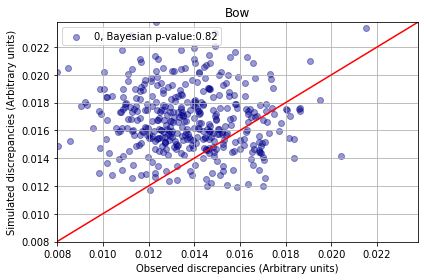

In [ ]:
discs_g31=np.zeros((len(Cons),400)) 
disco_g31=np.zeros((len(Cons),400)) 


#plt.show()

fig, ax = plt.subplots()
#for ii, ax in enumerate(axes.flat, start=0):
#for ii in range(len(Cons)):
for ii in range(Nlen):
  disc_sgg_s(ii,rr_g31[ii,:,:],x,y ,discs_g31,disco_g31)
  ax.legend(loc='upper left',frameon=True)
  ax.set_xlabel('Observed discrepancies (Arbitrary units)')
  ax.set_ylabel('Simulated discrepancies (Arbitrary units)')
  ax.set_title(Cons_names[ii])
  ax.grid()
fig.tight_layout()

plt.show()

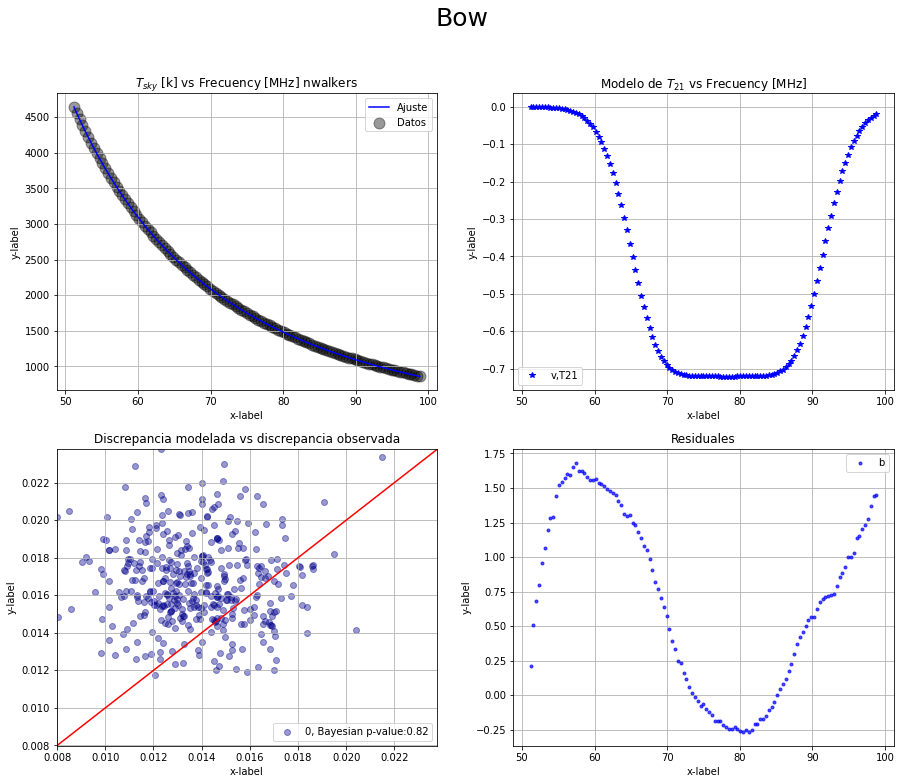

In [ ]:
for i in range(Nlen):
  fig, axs = plt.subplots(2, 2,figsize=(15, 12))
  fig.suptitle(Cons_names[i],fontsize=25)
  a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1,sigma1=cc_g31[i]
  axs[0, 0].plot(x,T_sky_s(x,*cc_g31[i]),color=Col[i], label='Ajuste')
  axs[0, 0].scatter(x,y,color='black',s=120,alpha=0.4,label='Datos')
  axs[0, 0].set_title(r'$T_{sky}$ [k] vs Frecuency [MHz] nwalkers')


  axs[0, 1].plot(x,T_21(x,A1,v01,w1,tau1),'k*',label='v,T21',color=Col[i])
  axs[0, 1].set_title(r'Modelo de $T_{21}$ vs Frecuency [MHz]')

  axs[1, 0].scatter(disco_g31[i],discs_g31[i],color='darkblue',alpha=0.4,label=str(i)+", Bayesian p-value:"+str(np.round((disco_g31[i]<discs_g31[i]).sum()*1./len(disco_g31[i]),2)))
  dmax=np.max(np.hstack((disco_g31[i],discs_g31[i])))
  dmin=np.min(np.hstack((disco_g31[i],discs_g31[i])))
  ppp=np.linspace(0,dmax+10,2)
  axs[1, 0].plot(ppp,ppp,c='r')
  axs[1, 0].set_title('Discrepancia modelada vs discrepancia observada')
  axs[1, 0].set_xlim(dmin,dmax)
  axs[1, 0].set_ylim(dmin,dmax)


  axs[1, 1].plot(x,(y-T_sky_s(x,*cc_g31[i])),'.',alpha=0.7,color=Col[i],label=str(Col[i]))
  axs[1, 1].set_title('Residuales')

  for ax in axs.flat:
      ax.set(xlabel='x-label', ylabel='y-label')

  # Hide x labels and tick labels for top plots and y ticks for right plots.
  for ax in axs.flat:
      ax.legend()
      ax.grid()

In [ ]:

var_names=vnames
Pymcee_data=az.from_pymc3(trace_pred)
az.rhat(Pymcee_data)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<xarray.Dataset>
Dimensions:   (mu_dim_0: 123)
Coordinates:
  * mu_dim_0  (mu_dim_0) int64 0 1 2 3 4 5 6 7 ... 116 117 118 119 120 121 122
Data variables:
    a0        float64 1.001
    a1        float64 1.001
    a2        float64 1.002
    a3        float64 1.002
    a4        float64 1.001
    A         float64 1.0
    v0        float64 1.001
    w         float64 0.9998
    tau       float64 0.9996
    mu        (mu_dim_0) float64 1.001 1.001 1.001 1.001 ... 1.002 1.002 1.002
    sigma     float64 1.0

# Pyemcee absorción ok

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, tau, w, v0, A, a4, a3, a2, a1, a0]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 1442 seconds.
There were 566 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 749 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


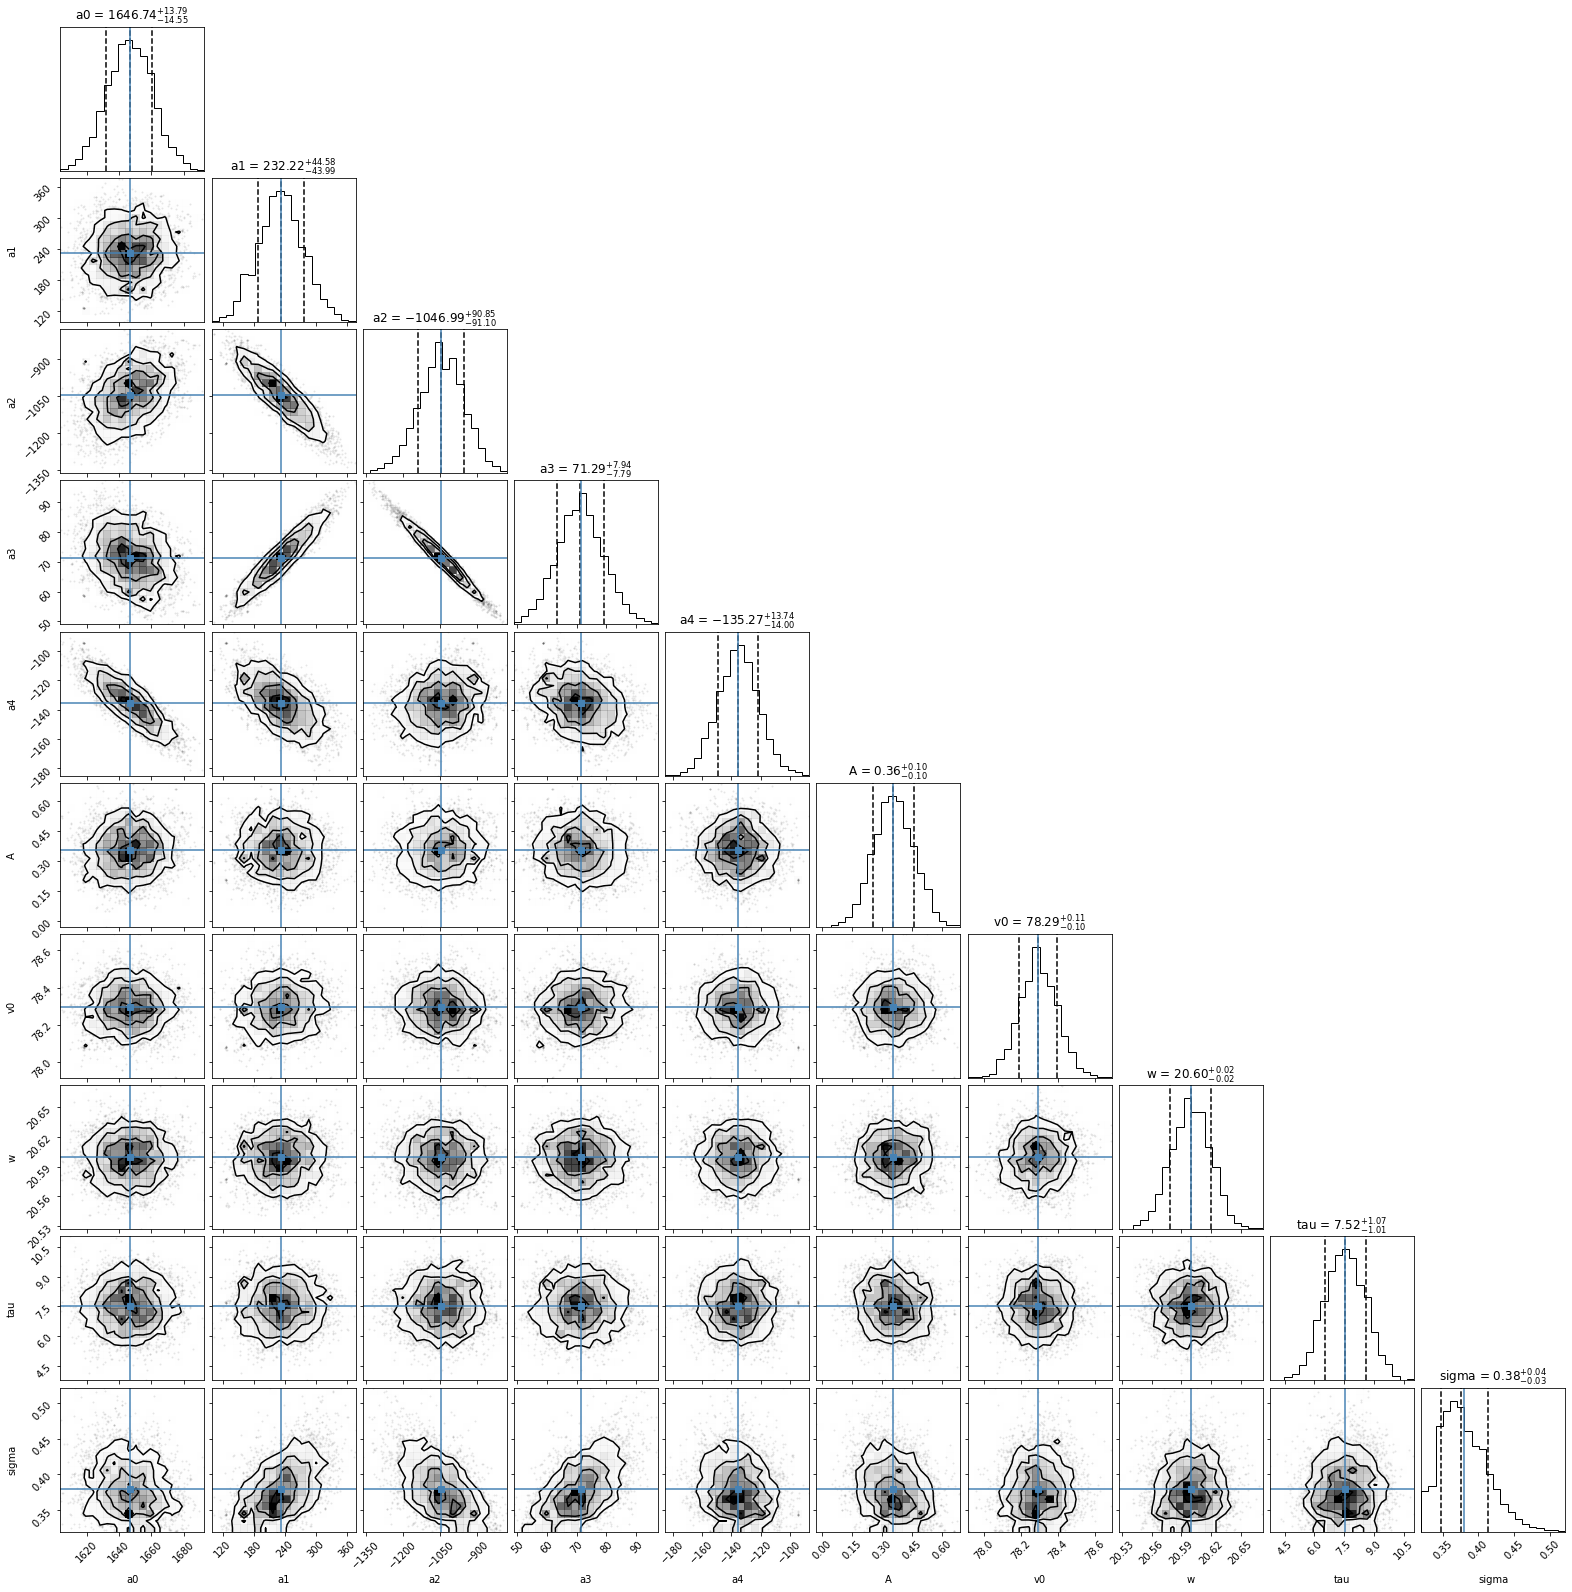

In [ ]:
d1=x_C # Valores de frecuencia [Mhz]
d2=y_C # Valores de la temperatura [Mk]
N=2000
cc_g30=np.zeros((len(Cons),len(Cons[0])))  # Este arreglo vacio, va a contener los valores principales de los parametros
rr_g30=np.zeros((len(Cons),2*N,len(Cons[0]))) #Este arreglo vacio va a contener los n walkers  de los parametross
#v=d1.freq-d1.freq.mean()/d1.freq.std()
v=d1#.freq
vc=78.0
Nlen=1
for i in range(Nlen):
  a_0,a_1,a_2,a_3,a_4,A_,v_0,w_,tau_,sigma_=Cons[i]
  with pm.Model() as pred_model:
        vc=78.01
        a0=pm.Normal('a0',mu=1590,sd=20)
        a1=pm.Normal('a1',mu=660,sd=80)
        a2=pm.Normal('a2',mu=-1100,sd=100)
        a3=pm.Normal('a3',mu=690,sd=80)
        a4=pm.Normal('a4',mu=-165,sd=20)
    #    TF=(a0*(v)**-2.5+a1*(v)**-2.5*np.log10(v)+a3*(v)**-4.5+a4*(v)**-2.0+a2*(v)**-2.5*np.log10(v)**2)
        A=pm.Normal('A',mu=0.2,sd=0.1)
        v0=pm.Normal('v0',mu=78.3,sd=0.1)
        w=pm.Normal('w',mu=20.6,sd=0.02)
        tau=pm.Normal('tau',mu=8,sd=1.0)
    #    T21=-A*(1-np.e**(tau*np.e**(4*(v-v0)**2/w**2*(np.log10(-1/tau*np.log10((1+np.e**-tau)/2))))))/(1-np.e**-tau)
        B=((4*(v0-v)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
        mu=pm.Deterministic('mu',a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2  -  A*(1-(np.exp(-tau*np.exp(B))))/(1-(np.e**(-tau))))
    #    mu=pm.Deterministic('mu',T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau))
        sigma=pm.Uniform('sigma',lower=0.2,upper=2.9)
        Tsky=pm.Normal('Tsky',mu=mu,sd=sigma,observed=d2)
        trace_pred=pm.sample(N,tune=N)
  filt1=np.array([np.logical_not('_interval__' in k) for k in trace_pred.varnames])
  filt2=np.array([np.logical_not('mu' in k) for k in trace_pred.varnames])
  vnames=np.array(trace_pred.varnames)[filt1&filt2] # arreglo con los nombres
  trace_array=np.array([trace_pred[i] for i in vnames]).T
  mean_pars=trace_array.mean(axis=0)

  #corner.corner(trace_array,labels=vnames,quantiles=[0.16, 0.5, 0.84],truths=mean_pars,show_titles=True)
  corner.corner(trace_array,labels=vnames,quantiles=[0.16, 0.5, 0.84],truths=trace_array.mean(axis=0),show_titles=True) 
  plt.show()
  cc_g30[i]=mean_pars
  rr_g30[i]=trace_array

Rejection rate = 0 %
Bayesian p-value: 0.0


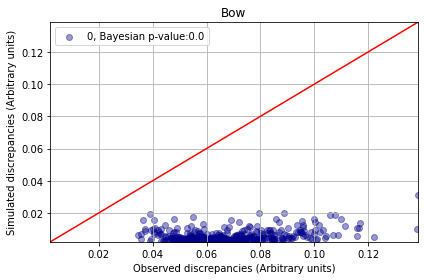

In [ ]:
discs_g30=np.zeros((len(Cons),400)) 
disco_g30=np.zeros((len(Cons),400)) 


#plt.show()

fig, ax = plt.subplots()
#for ii, ax in enumerate(axes.flat, start=0):
#for ii in range(len(Cons)):
for ii in range(Nlen):
  disc_sgg_s(ii,rr_g30[ii,:,:],x,y ,discs_g30,disco_g30)
  ax.legend(loc='upper left',frameon=True)
  ax.set_xlabel('Observed discrepancies (Arbitrary units)')
  ax.set_ylabel('Simulated discrepancies (Arbitrary units)')
  ax.set_title(Cons_names[ii])
  ax.grid()
fig.tight_layout()

plt.show()

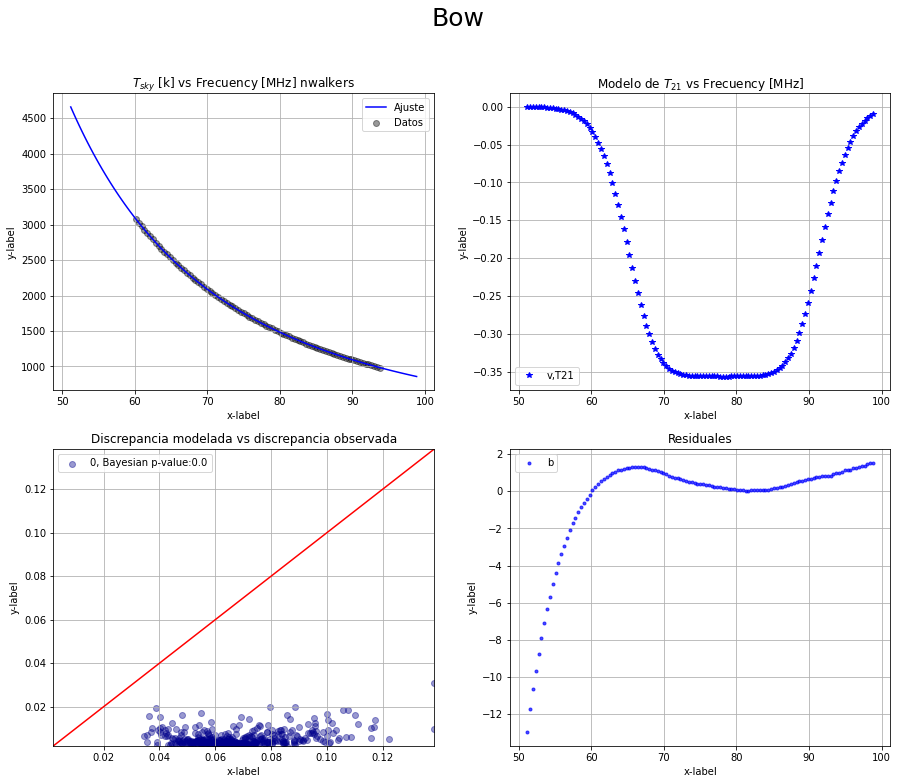

In [ ]:
for i in range(Nlen):
  fig, axs = plt.subplots(2, 2,figsize=(15, 12))
  fig.suptitle(Cons_names[i],fontsize=25)
  a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1,Sigma1=cc_g30[i]
  axs[0, 0].plot(x,T_sky_s(x,*cc_g30[i]),color=Col[i], label='Ajuste')
  axs[0, 0].scatter(x_C,y_C,color='black',alpha=0.4,label='Datos')
  axs[0, 0].set_title(r'$T_{sky}$ [k] vs Frecuency [MHz] nwalkers')


  axs[0, 1].plot(x,T_21(x,A1,v01,w1,tau1),'k*',label='v,T21',color=Col[i])
  axs[0, 1].set_title(r'Modelo de $T_{21}$ vs Frecuency [MHz]')

  axs[1, 0].scatter(disco_g30[i],discs_g30[i],color='darkblue',alpha=0.4,label=str(i)+", Bayesian p-value:"+str(np.round((disco_g30[i]<discs_g30[i]).sum()*1./len(disco_g30[i]),2)))
  dmax=np.max(np.hstack((disco_g30[i],discs_g30[i])))
  dmin=np.min(np.hstack((disco_g30[i],discs_g30[i])))
  ppp=np.linspace(0,dmax+10,2)
  axs[1, 0].plot(ppp,ppp,c='r')
  axs[1, 0].set_title('Discrepancia modelada vs discrepancia observada')
  axs[1, 0].set_xlim(dmin,dmax)
  axs[1, 0].set_ylim(dmin,dmax)


  axs[1, 1].plot(x,(y-T_sky_s(x,*cc_g30[i])),'.',alpha=0.7,color=Col[i],label=str(Col[i]))
  axs[1, 1].set_title('Residuales')

  for ax in axs.flat:
      ax.set(xlabel='x-label', ylabel='y-label')

  # Hide x labels and tick labels for top plots and y ticks for right plots.
  for ax in axs.flat:
      ax.legend()
      ax.grid()

In [ ]:

var_names=vnames
Pymcee_data=az.from_pymc3(trace_pred)
az.rhat(Pymcee_data)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<xarray.Dataset>
Dimensions:   (mu_dim_0: 87)
Coordinates:
  * mu_dim_0  (mu_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 78 79 80 81 82 83 84 85 86
Data variables:
    a0        float64 1.003
    a1        float64 1.019
    a2        float64 1.015
    a3        float64 1.017
    a4        float64 1.007
    A         float64 1.001
    v0        float64 1.002
    w         float64 1.001
    tau       float64 1.0
    mu        (mu_dim_0) float64 1.006 1.005 1.004 1.003 ... 1.001 1.001 1.002
    sigma     float64 1.032